In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from PIL import Image, ImageDraw
import math

In [ ]:
def show_image(img, new_title, scale=2.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.title(new_title)
    plt.gray() 
    plt.axis('off')
    plt.show()



# Part 1: SLIC Superpixels 

## Overview

Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential object contours, and thereby can replace the rigid pixel grid structure. Due to the reduced complexity, superpixels are becoming popular for various computer vision applications, e.g., multiclass object segmentation, depth estimation, human pose estimation, and object localization.

Reference Paper: http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf


## Data


In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
To: /content/Part1_SLIC.zip
100% 6.19M/6.19M [00:00<00:00, 33.7MB/s]
Archive:  /content/Part1_SLIC.zip
   creating: /content/Part1_SLIC/
  inflating: /content/Part1_SLIC/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/._.DS_Store  
   creating: /content/Part1_SLIC/sample_data/
   creating: /content/Part1_SLIC/BSD_data/
  inflating: /content/Part1_SLIC/sample_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._.DS_Store  
   creating: /content/Part1_SLIC/sample_data/images/
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._images  
   creating: /content/Part1_SLIC/sample_data/groundTruth/
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._groundTruth  
  inflating: /content/Part1_SLIC/BSD_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/BSD_data/._.DS_Store  
   creating: /content/Part1_SLIC/BSD_data/images/
   creating: /content/Part1_SLIC/BSD_data/groun

## Helper Functions:

### Code 

In [ ]:
# A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixel(object):

    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = []

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w

# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w, img):
    return SuperPixel(img[h,w][0],img[h,w][1],img[h,w][2], h, w)

def display_clusters(img, clusters, title):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1], 0] = c.l
            image[p[0],p[1], 1] = c.a
            image[p[0],p[1], 2] = c.b
        # image[int(c.h), int(c.w), 0] = 0
        # image[int(c.h), int(c.w), 1] = 0
        # image[int(c.h), int(c.w), 2] = 0
    rgb_arr = color.lab2rgb(image) 
    show_image(rgb_arr, title)


def display_clusters_hsv2rgb(img, clusters, title):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1], 0] = c.l
            image[p[0],p[1], 1] = c.a
            image[p[0],p[1], 2] = c.b
        # image[int(c.h), int(c.w), 0] = 0
        # image[int(c.h), int(c.w), 1] = 0
        # image[int(c.h), int(c.w), 2] = 0
    rgb_arr = color.hsv2rgb(image) 
    show_image(rgb_arr, title)

In [ ]:
# Functions for Simple Linear Iterative Clustering (SLIC)
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)
def compute_metrics(true_img, my_img):
  error, precision, recall = adapted_rand_error(true_img, my_img)
  splits, merges = variation_of_information(true_img, my_img)
  return error, recall


def initialize_cluster_centers(S , image, img_h, img_w, clusters):
    ####   ####
    # Reference used: https://darshita1405.medium.com/superpixels-and-slic-6b2d8a6e4f08
    # on the image of N pixels. N = img_h X img_w. Hint: clusters.append(make_superPixel(h, w, image)) to create each cluster/super-pixel.
    # print("initializing cluster centers")
    h = S // 2
    w = S // 2
    while h < img_h:
        while w < img_w:
            clusters.append(make_SuperPixel(h, w, image))
            w += S
        w = S // 2
        h += S
    return clusters


def relocate_cluster_center_at_lowgrad(clusters, image):
    ####   ####
    # To Do:
    # for each cluster c, reassign cluster to the pixel having smallest gradient value.
    # Step 1: compute gradient wrt cluster-center c.h, c.w in 3X3 neighborhood of cluster center.
    # Step 2: Similarly, compute gradient for each pixel in 3X3 spatial neighborhood of cluster c.
    # Step 3. Reassign cluster-center to the pixel (x,y) having the lowest gradient. 
    # Hint: c.update(img[x,y][0], img[h,w][1], img[x,y][2], x, y)
    # compute gradient of image

    # print("Sample cluster elements", clusters[0].l, clusters[0].a, clusters[0].b, clusters[0].h, clusters[0].w)

    def gradientMagnitude(im, sigma):
      # TODO remove angle part
      '''
      im: input image
      sigma: standard deviation value to smooth the image

      outputs: gradient magnitude and gradient direction of the image
      '''
      blurred_image = cv2.GaussianBlur(im, (3, 3), sigma)
      # blurred_image = im
      gx =[]
      gy = []
      for i in range(3):
        # Finding RGB gradients
        grad_x = cv2.Sobel(np.float32(blurred_image[:, :, i]), cv2.CV_64F, 1, 0, 3)
        gx.append(grad_x)
        grad_y = cv2.Sobel(np.float32(blurred_image[:, :, i]), cv2.CV_64F, 0, 1, 3)
        gy.append(grad_y)
      magnitude = []
      angle =[]
      for i in range(3):
        # Calculate mag and phase
        mag, ang = cv2.cartToPolar(gx[i], gy[i], angleInDegrees = True)
        magnitude.append(mag)
        angle.append(ang)
      size = im.shape
      orientation = np.zeros((size[0], size[1]) )
      final_mag = np.zeros((size[0], size[1]))
      for i in range(size[0]):
        for j in range(size[1]):
          n_list = [magnitude[0][i, j], magnitude[1][i, j], magnitude[2][i, j]]
          max_val = max(n_list)
          max_index = n_list.index(max_val)
          orientation[i, j] = angle[max_index][i, j]
          final_mag[i, j]= np.sqrt(np.square(magnitude[0][i, j]) + np.square(magnitude[1][i, j]) + np.square(magnitude[2][i, j]))

      return final_mag, orientation

    mag, orientn= gradientMagnitude(image, sigma=1.2) # find magnitude of gradient for entire image

    for c in clusters:
      center_h = c.h
      center_w = c.w
      # get 3x3 gradient image
      temp_cluster = mag[center_h-1:center_h+2, center_w-1:center_w+2 ] # size 3x3

      h_new, w_new= np.where(temp_cluster == np.amax(temp_cluster)) # find max in the gradient image
      h_new = h_new[0]
      w_new = w_new[0]
      
      # update cluster centers
      c.update(image[center_h + h_new -1, center_w + w_new -1, 0], image[center_h + h_new -1, center_w + w_new -1, 1], image[center_h + h_new -1, center_w + w_new -1, 2], center_h + h_new -1, center_w + w_new -1)

    return None

def assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis, m, n):
    
    # To Do: Compare each pixel to cluster center within 2S pixel distance and assign to nearest cluster using the "distance metric"
    # (involving both color and spatial dimensions of pixel and cluster, 
    # Hints: 
    # 1. use "dis" matrix for comparing distances.
    # 2. You can use c.pixels.append((h, w)) to keep track of cluster-assignments.
    # print("assigning cluster")
    number = 1
    for c in clusters:
      # take cluster center, take 2sx2s region of image, find dis
      # update dis- if new dis is less than old dis, update and assign to new cluster, else don't update dis
      for h in range(int(c.h - (S)), int(c.h + (S))):
        if h < 0 or h >= img_h: continue
        for w in range(int(c.w - ( S)), int(c.w + (S))):
          if w < 0 or w >= img_w: continue
          l, a, b = image[h,w]
          Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
          Ds = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
          D_temp = math.sqrt(math.pow(Dc / m, 2) + math.pow(Ds/n, 2))
          if D_temp < dis[h, w ]:    
            dis[h, w] = D_temp
            c.pixels.append((h, w))
            cluster_tag[h, w] = number
            number = number + 1

    total_clusters = len(clusters)
    sum = 0
    for c in clusters:
      size = len(c.pixels)
      temp_sum = 0
      for p in c.pixels:
        temp_sum = temp_sum + dis[p[0], p[1]]
      temp_sum = temp_sum/size
      sum = sum + temp_sum
    
    avg = sum/total_clusters
    # print("Average error ", avg)

    return avg

def update_clusters(clusters, img):
    ####   ####
    # To Do: For each cluster, update the cluster center with mean of the pixels assigned (c.pixels)
    for c in clusters:
      h_sum = 0
      w_sum = 0
      for p in c.pixels:
        # print(tmp.shape)
        h_sum = h_sum + p[0]
        w_sum = w_sum + p[1]
      
      # if len(c.pixels)==0:
      #   h_mean = 0
      #   w_mean = 0
      # else:
      #   h_mean = int(h_sum/len(c.pixels))
      #   w_mean = int(w_sum/len(c.pixels))

      h_mean = int(h_sum/len(c.pixels))
      w_mean = int(w_sum/len(c.pixels))

      c.update(img[h_mean, w_mean, 0], img[h_mean, w_mean, 1], img[h_mean, w_mean, 2], h_mean, w_mean)
    return None

def compute_res_error(old_clusters, new_clusters):
    ####   ####
    error = 0.0
    # error = Compute L1 distance between previous cluster-centres and new cluster centers.
    for i in range(len(old_clusters)):
      error = error + abs(old_clusters[i].h - new_clusters[i].h) + abs(old_clusters[i].w - new_clusters[i].w)  + abs(old_clusters[i].l - new_clusters[i].l) + abs(old_clusters[i].a - new_clusters[i].a) + abs(old_clusters[i].b - new_clusters[i].b) 

    return error


def slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis, m, n):

    # Initialize cluster centers on pixel grid in steps S
    clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)
    # print(len(clusters))
    # print(clusters[2])
    # Move centers to position in 3x3 window with smallest gradient.
    relocate_cluster_center_at_lowgrad(clusters, image)

    # You can play around with these hyper-params.
    res_err = 123456789.0 # init residual_error with a very large value (choose as per your understanding.)
    threshold = 0.01 # tune this
    error_mat = []
    error_averages =[]

    while(res_err >= threshold):

      avg = assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis, m, n)
      error_averages.append(avg)
      old_clusters = copy.deepcopy(clusters)
      update_clusters(clusters, image)

      res_err = compute_res_error(old_clusters, clusters)
      error_mat.append(res_err)
      
      if res_err<threshold:
        break
    
    print(" Initial Error = ", error_averages[0] )
    print(" Error at Convergence = ", error_averages[-1] )
    return clusters    


k =  1024
N =  154401
S =  12
 Initial Error =  0.9161750243626976
 Error at Convergence =  0.7466485655199285
Segmented Image for weights  m =  10 n =  7


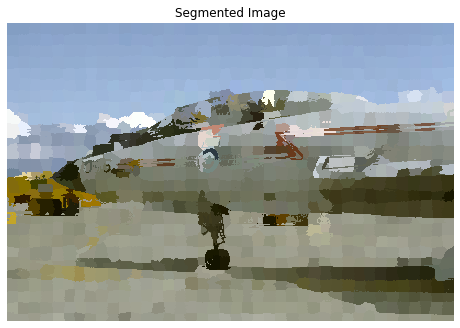

 Initial Error =  0.5358344290592263
 Error at Convergence =  0.4364568222589753
Segmented Image for weights  m =  17 n =  12


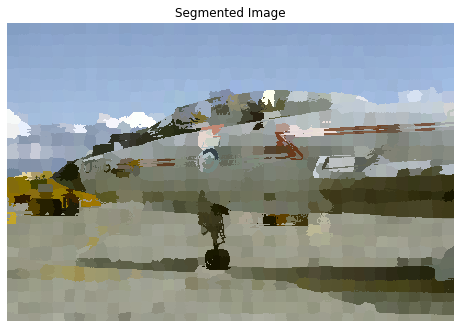

 Initial Error =  0.37389559612400547
 Error at Convergence =  0.30517430619321306
Segmented Image for weights  m =  25 n =  17


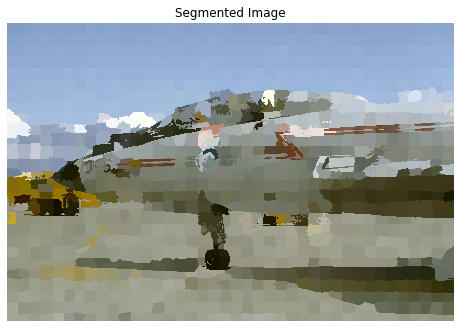

In [ ]:
# TASK: Choose one image, try three different weights on the color and spatial feature and show the three segmentation results. Describe what you observe.
# Main Block:
img_path = "/content/Part1_SLIC/BSD_data/images/10081.jpg"

# Load image and convert it from an unsigned 8-bit integer to a floating point data type.
image = img_as_float(io.imread(img_path))
# show_image(image)
# convert RGB to LAB
image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width
# print("image shape", image.shape)

# k: Number of clusters/superpixels.
k = 1024
N = img_h * img_w  # Total pixels in the image
S = int(math.sqrt(N /k)) # Average size of each superpixel
m = [10, 17, 25]  # weight for color
n = [S-5, S, S+5]  # weight for spatial features
print("k = ", k)
print("N = ", N)
print("S = ", S)
# print("m = ", m)
# print("n = ", n)


for i in range(3):
  clusters = []
  # cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
  cluster_tag = np.zeros((img_h, img_w))
  dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

  clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis, m[i], n[i])
  print("Segmented Image for weights ","m = ", m[i], "n = ", n[i])
  display_clusters(image, clusters, 'Segmented Image')

  

 Initial Error =  0.5113488900986541
 Error at Convergence =  0.37066025772718675
Segmented Image for weights  k =  64 m =  34 n =  49


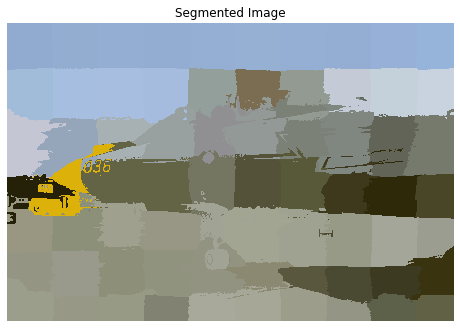

In [ ]:
# TASK: Choose one image and show three superpixel results with different number of K. Here, K = 64
# k: Number of clusters/superpixels.
k = np.array([64, 256, 1024])
N = img_h * img_w  # Total pixels in the image
# S = int(math.sqrt(N /k)) # Average size of each superpixel
S = np.array([int(math.sqrt(N /int(k[0]))), int(math.sqrt(N /int(k[1]))), int(math.sqrt(N /int(k[2])))])

m = [34, 17, 12]  # weight for color
n = [S[0], S[1], S[2]]  # weight for spatial features
# print("k = ", k)
# print("N = ", N)
# print("S = ", S)
# print("m = ", m)
# print("n = ", n)

clusters = []
# cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
cluster_tag = np.zeros((img_h, img_w))
dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

clusters = slic_algorithm(S[0], image, img_h, img_w, clusters, cluster_tag, dis, m[0], n[0])

print("Segmented Image for weights ", "k = ", k[0], "m = ", m[0], "n = ", n[0])
display_clusters(image, clusters, 'Segmented Image')


 Initial Error =  0.5967954307624798
 Error at Convergence =  0.4680459850939283
Segmented Image for weights  k =  256 m =  17 n =  24


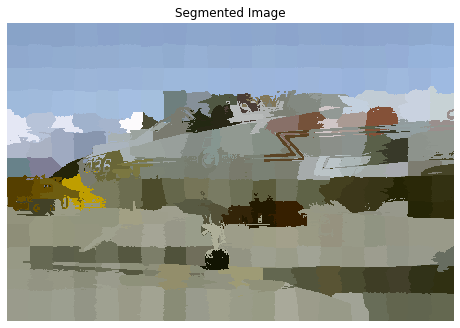

In [ ]:
# TASK: Choose one image and show three superpixel results with different number of K. Here, K = 256
clusters = []
# cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
cluster_tag = np.zeros((img_h, img_w))
dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

clusters = slic_algorithm(S[1], image, img_h, img_w, clusters, cluster_tag, dis, m[1], n[1])

print("Segmented Image for weights ", "k = ", k[1], "m = ", m[1], "n = ", n[1])
display_clusters(image, clusters, 'Segmented Image')

 Initial Error =  0.6066878811738151
 Error at Convergence =  0.48460404560887393
Segmented Image for weights  k =  1024 m =  12 n =  12


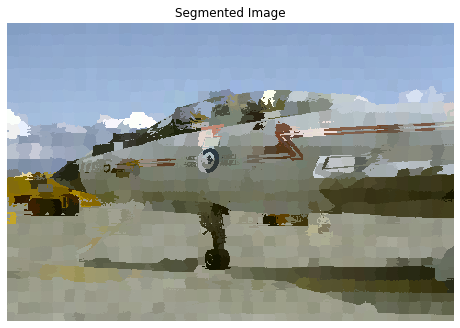

In [ ]:
# TASK: Choose one image and show three superpixel results with different number of K. Here, K = 1024
clusters = []
# cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
cluster_tag = np.zeros((img_h, img_w))
dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

clusters = slic_algorithm(S[2], image, img_h, img_w, clusters, cluster_tag, dis, m[2], n[2])

print("Segmented Image for weights ", "k = ", k[2], "m = ", m[2], "n = ", n[2])
display_clusters(image, clusters, 'Segmented Image')

Processing image: 14085
 Initial Error =  0.7985833349717814
 Error at Convergence =  0.5868655120961166
Segmentation error =  0.38974721181259686
Boundary recall =  0.4391172274483579
Segmented Image  k =  64 and weights  m =  17 n =  49


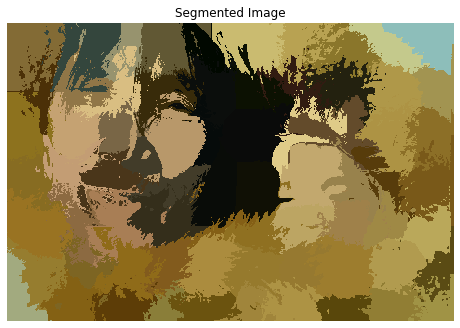

 Initial Error =  0.6885111694876898
 Error at Convergence =  0.5626596862104803
Segmentation error =  0.38974721181259686
Boundary recall =  0.4391172274483579
Segmented Image  k =  256 and weights  m =  17 n =  24


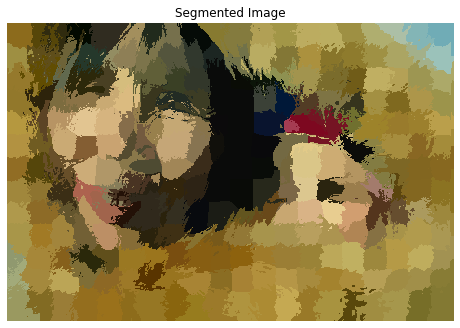

 Initial Error =  0.6135143005897493
 Error at Convergence =  0.5143960350368317
Segmentation error =  0.3897387247620113
Boundary recall =  0.43912333444236845
Segmented Image  k =  1024 and weights  m =  17 n =  12


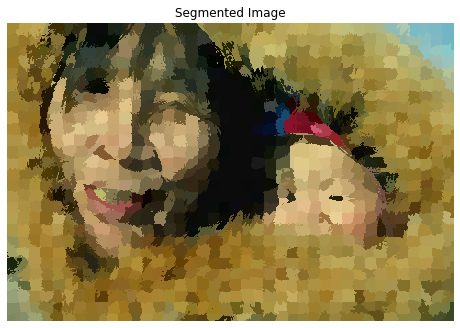

Processing image: 14092
 Initial Error =  0.711563126203016
 Error at Convergence =  0.5202207839221101
Segmentation error =  0.28096431918934694
Boundary recall =  0.5613345417794108
Segmented Image  k =  64 and weights  m =  17 n =  49


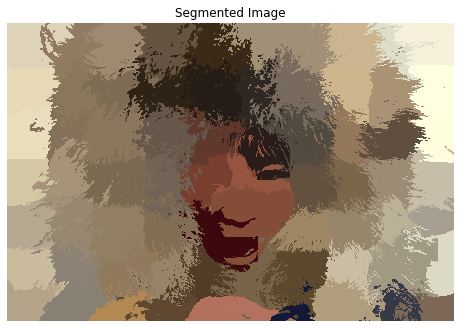

 Initial Error =  0.6401842253001989
 Error at Convergence =  0.5073282403611472
Segmentation error =  0.28096431918934694
Boundary recall =  0.5613345417794108
Segmented Image  k =  256 and weights  m =  17 n =  24


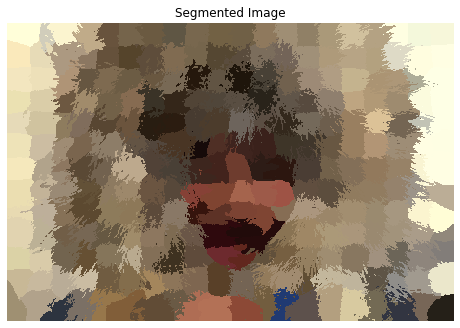

 Initial Error =  0.5690991677064179
 Error at Convergence =  0.4781238236783145
Segmentation error =  0.28096431918934694
Boundary recall =  0.5613345417794108
Segmented Image  k =  1024 and weights  m =  17 n =  12


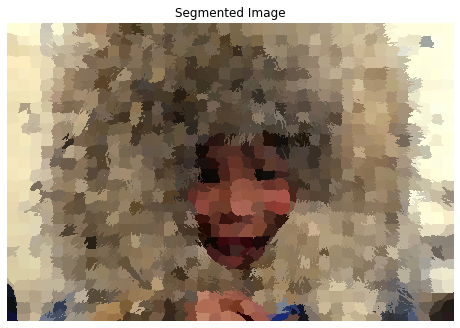

Processing image: 15011
 Initial Error =  0.8285965988208475
 Error at Convergence =  0.5493873237012231
Segmentation error =  0.8017734312294507
Boundary recall =  0.1100180013463794
Segmented Image  k =  64 and weights  m =  17 n =  49


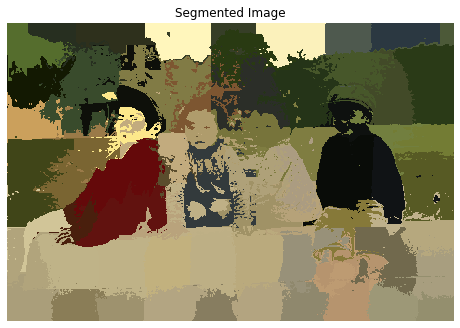

 Initial Error =  0.717169842111218
 Error at Convergence =  0.5556983329242201
Segmentation error =  0.801775629338662
Boundary recall =  0.1100164988719255
Segmented Image  k =  256 and weights  m =  17 n =  24


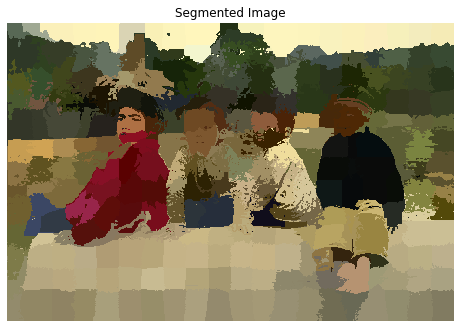

 Initial Error =  0.6145380147271597
 Error at Convergence =  0.4983887281626904
Segmentation error =  0.8017739874593042
Boundary recall =  0.1100175513809821
Segmented Image  k =  1024 and weights  m =  17 n =  12


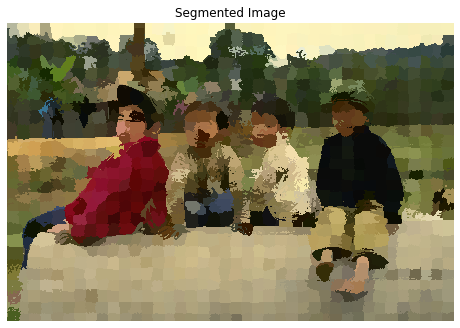

Processing image: 15062
 Initial Error =  0.8243621517185785
 Error at Convergence =  0.5844481501770351
Segmentation error =  0.6427409272105282
Boundary recall =  0.21747742865097958
Segmented Image  k =  64 and weights  m =  17 n =  49


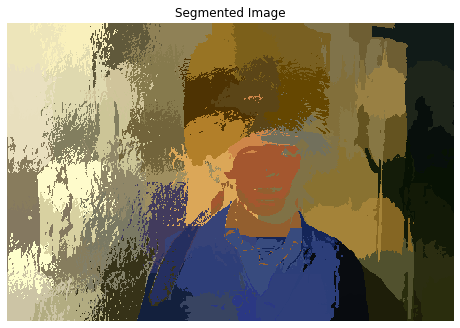

 Initial Error =  0.7693924527774522
 Error at Convergence =  0.5852123262478582
Segmentation error =  0.6427409272105282
Boundary recall =  0.21747742865097958
Segmented Image  k =  256 and weights  m =  17 n =  24


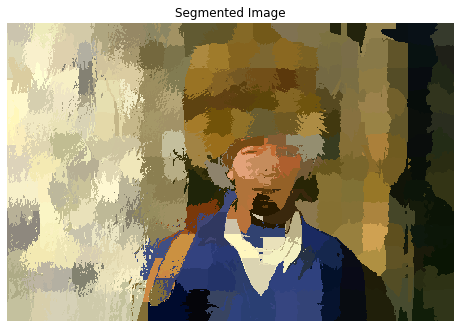

 Initial Error =  0.663377477706939
 Error at Convergence =  0.534437624125874
Segmentation error =  0.642740440519598
Boundary recall =  0.21747822813357506
Segmented Image  k =  1024 and weights  m =  17 n =  12


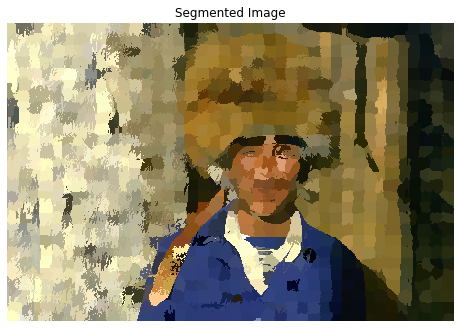

Processing image: 16068
 Initial Error =  0.7486477514031589
 Error at Convergence =  0.5182444374826615
Segmentation error =  0.5553204291341569
Boundary recall =  0.28591100754529697
Segmented Image  k =  64 and weights  m =  17 n =  49


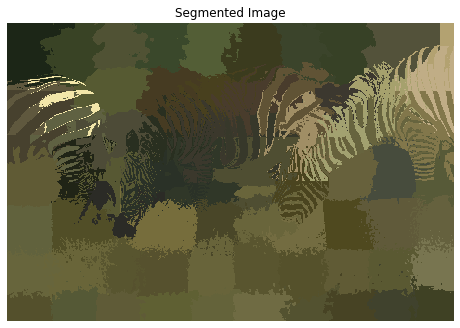

 Initial Error =  0.7361004501208419
 Error at Convergence =  0.5458305388921403
Segmentation error =  0.5553212572895361
Boundary recall =  0.28590965162027043
Segmented Image  k =  256 and weights  m =  17 n =  24


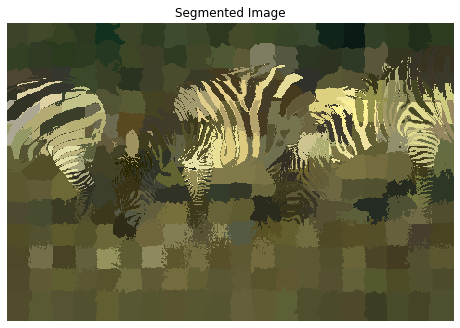

 Initial Error =  0.6783505656066787
 Error at Convergence =  0.5189244807502957
Segmentation error =  0.5553182275934976
Boundary recall =  0.28591242304704095
Segmented Image  k =  1024 and weights  m =  17 n =  12


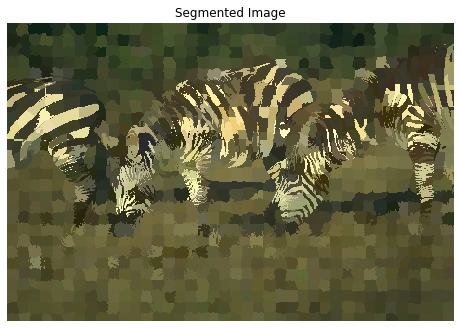

Processing image: 17067
 Initial Error =  0.7162112895218973
 Error at Convergence =  0.49024525596748075
Segmentation error =  0.7134938641447607
Boundary recall =  0.16720635481242713
Segmented Image  k =  64 and weights  m =  17 n =  49


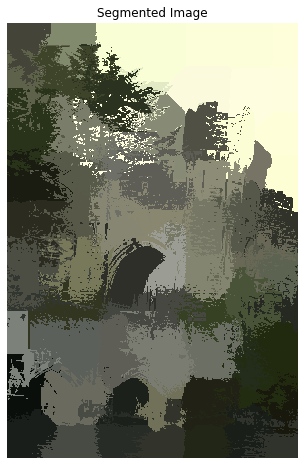

 Initial Error =  0.6566156063403719
 Error at Convergence =  0.5115751362500671
Segmentation error =  0.7134938641447607
Boundary recall =  0.16720635481242713
Segmented Image  k =  256 and weights  m =  17 n =  24


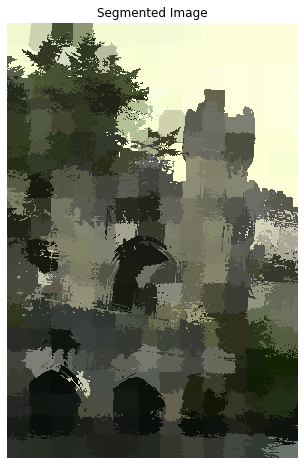

 Initial Error =  0.61598134611542
 Error at Convergence =  0.49925661758911144
Segmentation error =  0.7134895072077706
Boundary recall =  0.16720920782421286
Segmented Image  k =  1024 and weights  m =  17 n =  12


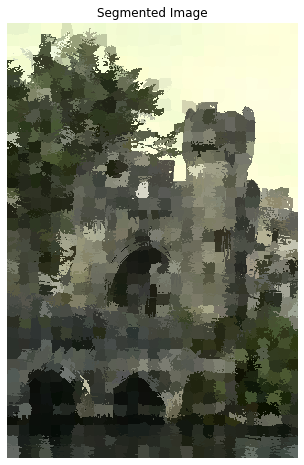

Processing image: 20069
 Initial Error =  0.7327405758085903
 Error at Convergence =  0.505468238015391
Segmentation error =  0.5795381890074174
Boundary recall =  0.26619287454949164
Segmented Image  k =  64 and weights  m =  17 n =  49


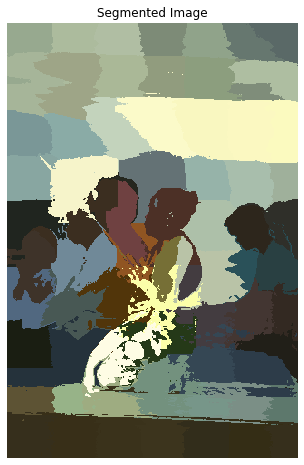

 Initial Error =  0.6576508917627757
 Error at Convergence =  0.5000374105773753
Segmentation error =  0.5795381890074174
Boundary recall =  0.26619287454949164
Segmented Image  k =  256 and weights  m =  17 n =  24


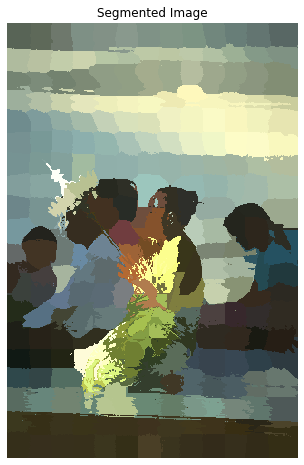

 Initial Error =  0.5628989373555076
 Error at Convergence =  0.4547071971973844
Segmentation error =  0.5795395975856027
Boundary recall =  0.2661941575065465
Segmented Image  k =  1024 and weights  m =  17 n =  12


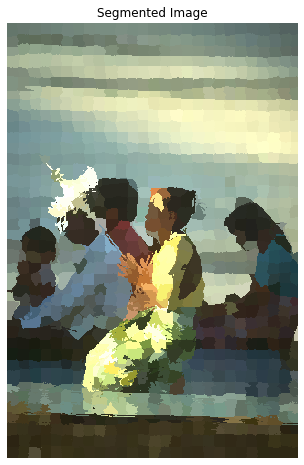

Processing image: 2018
 Initial Error =  0.7337051194182802
 Error at Convergence =  0.4916039270556571
Segmentation error =  0.7284351738907998
Boundary recall =  0.15711686596887875
Segmented Image  k =  64 and weights  m =  17 n =  49


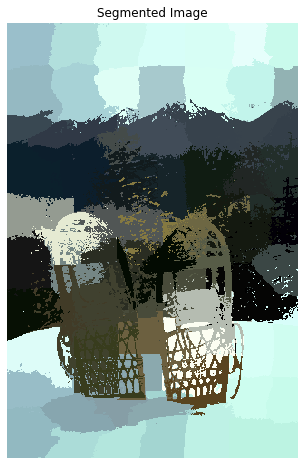

 Initial Error =  0.6638094440264647
 Error at Convergence =  0.5032724576998826
Segmentation error =  0.7284334678128872
Boundary recall =  0.15711757668636409
Segmented Image  k =  256 and weights  m =  17 n =  24


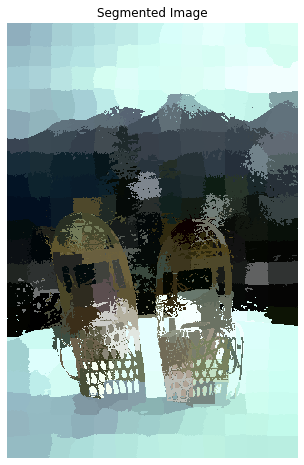

 Initial Error =  0.6105190322924345
 Error at Convergence =  0.474185318777327
Segmentation error =  0.7284346769454203
Boundary recall =  0.15711715348218344
Segmented Image  k =  1024 and weights  m =  17 n =  12


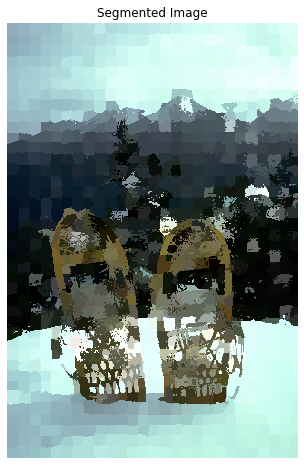

Processing image: 23050
 Initial Error =  1.0503468920225627
 Error at Convergence =  0.6440362665155058
Segmentation error =  0.9014360196493324
Boundary recall =  0.051836607005058925
Segmented Image  k =  64 and weights  m =  17 n =  49


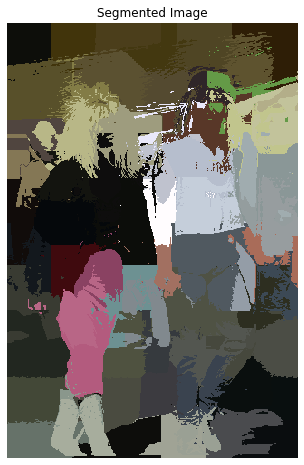

 Initial Error =  0.8245390739358234
 Error at Convergence =  0.5995925563551352
Segmentation error =  0.9014360641558984
Boundary recall =  0.05183658359823869
Segmented Image  k =  256 and weights  m =  17 n =  24


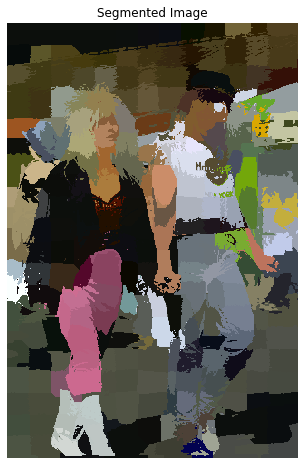

 Initial Error =  0.6720857051912585
 Error at Convergence =  0.5318746297162047
Segmentation error =  0.9014380956652808
Boundary recall =  0.05183551519015382
Segmented Image  k =  1024 and weights  m =  17 n =  12


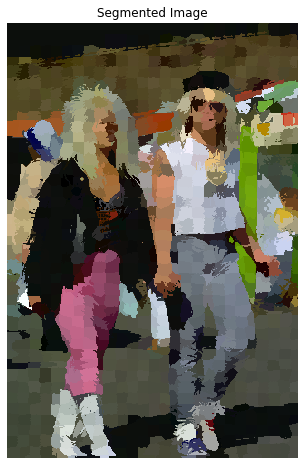

Processing image: 28083
 Initial Error =  0.6483965726114961
 Error at Convergence =  0.46988761376593424
Segmentation error =  0.567586025915625
Boundary recall =  0.2758486759307114
Segmented Image  k =  64 and weights  m =  17 n =  49


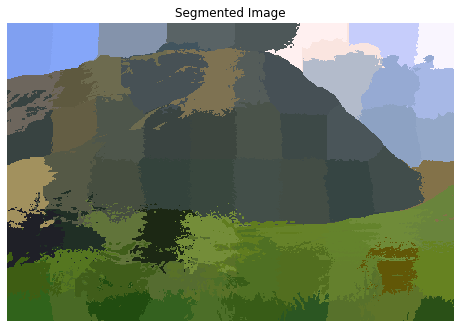

 Initial Error =  0.5859723117137704
 Error at Convergence =  0.48234913597695916
Segmentation error =  0.5675811517645155
Boundary recall =  0.27585101272029267
Segmented Image  k =  256 and weights  m =  17 n =  24


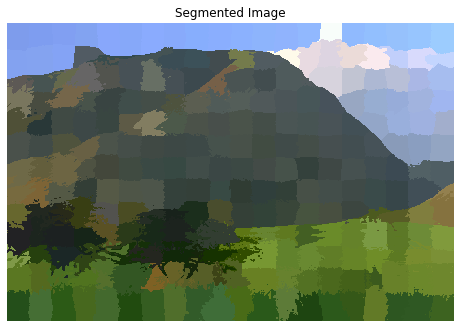

 Initial Error =  0.5351405383893909
 Error at Convergence =  0.44881907365020735
Segmentation error =  0.56758361014767
Boundary recall =  0.27585098958508
Segmented Image  k =  1024 and weights  m =  17 n =  12


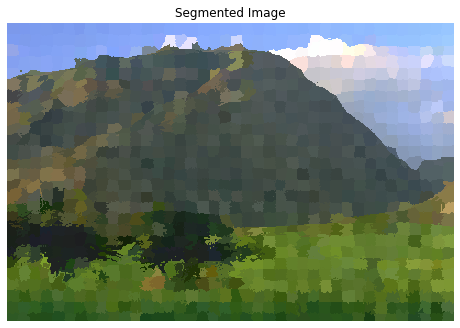

 Segmentation error for k = 64 :  [0.38974721 0.28096432 0.80177343 0.64274093 0.55532043 0.71349386
 0.57953819 0.72843517 0.90143602 0.56758603]
 Segmentation error for k = 256 :  [0.38974721 0.28096432 0.80177563 0.64274093 0.55532126 0.71349386
 0.57953819 0.72843347 0.90143606 0.56758115]
 Segmentation error for k = 1024 :  [0.38973872 0.28096432 0.80177399 0.64274044 0.55531823 0.71348951
 0.5795396  0.72843468 0.9014381  0.56758361]
 Recall for k = 64 :  [0.43911723 0.56133454 0.110018   0.21747743 0.28591101 0.16720635
 0.26619287 0.15711687 0.05183661 0.27584868]
 Recall for k = 256 :  [0.43911723 0.56133454 0.1100165  0.21747743 0.28590965 0.16720635
 0.26619287 0.15711758 0.05183658 0.27585101]
 Recall for k = 1024 :  [0.43912333 0.56133454 0.11001755 0.21747823 0.28591242 0.16720921
 0.26619416 0.15711715 0.05183552 0.27585099]
 Mean error [0.61610356 0.61610321 0.61610212]
Boundary error [0.25320596 0.25320598 0.25320731]


In [ ]:
# TASK: Run your algorithms on the subset (50 images) of Berkeley Segmentation Dataset (BSD) with K = 64, 256 and 1024 and report averaged run-time per image for the BSD.
from scipy.ndimage import label
imgPath = '/content/Part1_SLIC/BSD_data/images/';

imgList = ['14085', '14092', '15011', '15062', '16068', '17067', '20069', '2018', '23050', '28083']
# imgList = ['14085', '14092']
# metrics_array = np.zeros((3, 10))
error_matrix = np.zeros((3, len(imgList)))
recall_matrix = np.zeros((3, len(imgList)))
num = 0
for img_name in imgList:
  print("Processing image:", img_name)
  image = img_as_float(io.imread(imgPath+img_name+".jpg"))
  image = color.rgb2lab(image)
  true_image = scipy.io.loadmat('/content/Part1_SLIC/BSD_data/groundTruth/test/' + img_name + '.mat', squeeze_me=True)
  true_seg = true_image['groundTruth'][0].item()[0]

  img_h = image.shape[0] #  Height
  img_w = image.shape[1] #  Width
  # k: Number of clusters/superpixels.
  k = np.array([64, 256, 1024])
  N = img_h * img_w  # Total pixels in the image
  # S = int(math.sqrt(N /k)) # Average size of each superpixel
  S = np.array([int(math.sqrt(N /int(k[0]))), int(math.sqrt(N /int(k[1]))), int(math.sqrt(N /int(k[2])))])
  
  m = 17  # weight for color
  n = [S[0], S[1], S[2]]  # weight for spatial features

  for i in range(3):

    clusters = []
    cluster_tag = np.zeros((img_h, img_w))
    dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

    clusters = slic_algorithm(S[i], image, img_h, img_w, clusters, cluster_tag, dis, m, n[i])
    # print('cluster_tag dtype', cluster_tag.dtype)
    # print('true_seg dtype', true_seg.dtype)
    error, recall = compute_metrics(true_seg, label(cluster_tag.astype(np.uint16))[0])
    # print(cluster_tag)
    error_matrix[i, num] = error
    # error_matrix.append(error)
    # recall_matrix.append(recall)
    recall_matrix[i, num] = recall
    print("Segmentation error = ", error)
    print("Boundary recall = ", recall)
    print("Segmented Image ", "k = ", k[i],"and weights ", "m = ", m, "n = ", n[i])
    display_clusters(image, clusters, 'Segmented Image')
  num = num + 1

print(" Segmentation error for k = 64 : ", error_matrix[0, :])
print(" Segmentation error for k = 256 : ", error_matrix[1, :])
print(" Segmentation error for k = 1024 : ", error_matrix[2, :])
print(" Recall for k = 64 : ", recall_matrix[0, :])
print(" Recall for k = 256 : ", recall_matrix[1, :])
print(" Recall for k = 1024 : ", recall_matrix[2, :])
mean_error = np.mean(error_matrix, axis =1)
mean_recall = np.mean(recall_matrix, axis = 1)
print(" Mean error", mean_error)
print("Boundary error", mean_recall)

Text(0, 0.5, 'Mean boundary recall')

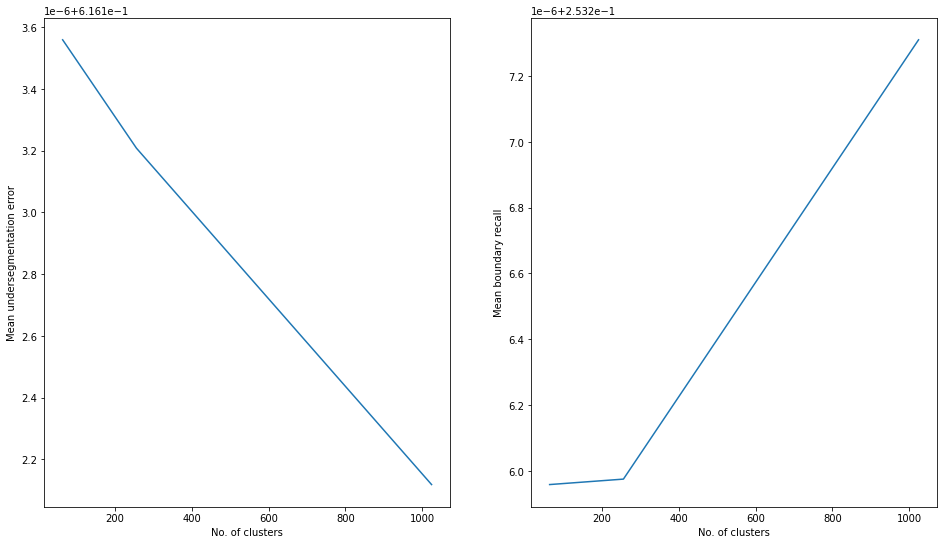

In [ ]:
# plotting undersegmentation error and recall
mean_error = np.mean(error_matrix, axis =1)
mean_recall = np.mean(recall_matrix, axis = 1)
x = np.array([64, 256, 1024])
fig, ax = plt.subplots(1, 2, figsize= (16, 9))
ax[0].plot(x, mean_error)
ax[0].set_xlabel('No. of clusters')
ax[0].set_ylabel('Mean undersegmentation error')

ax[1].plot(x, mean_recall)
ax[1].set_xlabel('No. of clusters')
ax[1].set_ylabel('Mean boundary recall')

Processing image: 14085
 Initial Error =  0.39471928565899234
 Error at Convergence =  0.32505075171090325
Segmentation error =  0.3897471846117767
Boundary recall =  0.43911898266502075
Segmented Image  k =  256 and weights  m =  10 n =  24


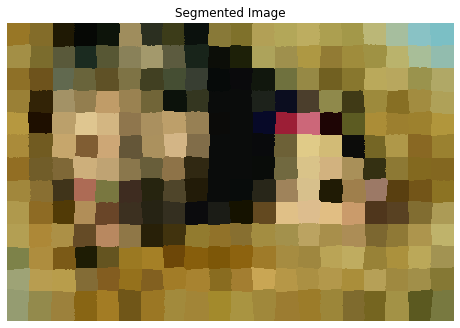

Processing image: 14092
 Initial Error =  0.3943168280114328
 Error at Convergence =  0.3246018552814995
Segmentation error =  0.28095159757531574
Boundary recall =  0.5613392448128054
Segmented Image  k =  256 and weights  m =  10 n =  24


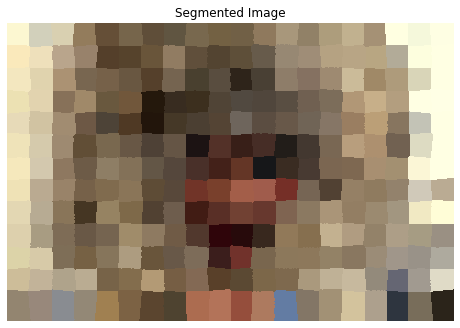

Processing image: 15011
 Initial Error =  0.39528567459826747
 Error at Convergence =  0.3253624559210839
Segmentation error =  0.801775629338662
Boundary recall =  0.1100164988719255
Segmented Image  k =  256 and weights  m =  10 n =  24


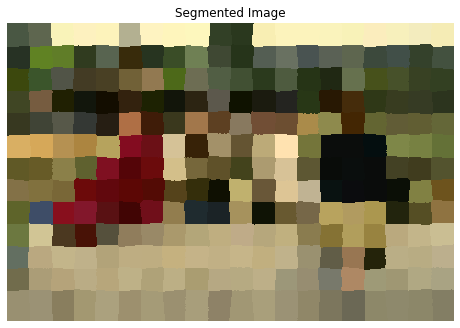

Processing image: 15062
 Initial Error =  0.39492102017827563
 Error at Convergence =  0.3254323952535092
Segmentation error =  0.642740440519598
Boundary recall =  0.21747822813357506
Segmented Image  k =  256 and weights  m =  10 n =  24


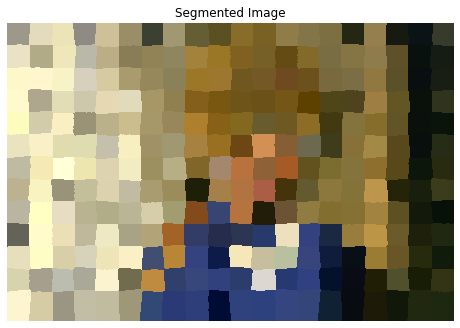

Processing image: 16068
 Initial Error =  0.39446370976287076
 Error at Convergence =  0.32494355183761314
Segmentation error =  0.5553150659754955
Boundary recall =  0.2859136323737231
Segmented Image  k =  256 and weights  m =  10 n =  24


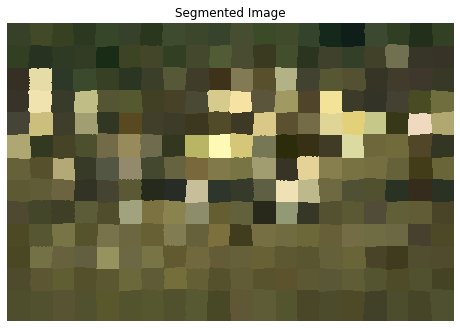

Processing image: 17067
 Initial Error =  0.3940932440367165
 Error at Convergence =  0.3247139409030655
Segmentation error =  0.7134914987414075
Boundary recall =  0.1672074249968783
Segmented Image  k =  256 and weights  m =  10 n =  24


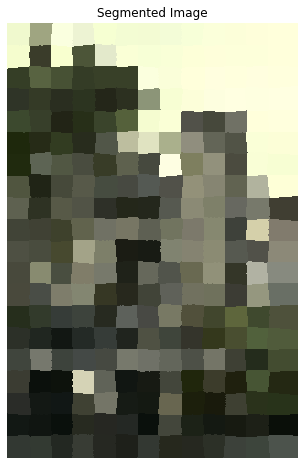

Processing image: 20069
 Initial Error =  0.3942640340833952
 Error at Convergence =  0.3248188731395363
Segmentation error =  0.5795365663994498
Boundary recall =  0.26619462672027966
Segmented Image  k =  256 and weights  m =  10 n =  24


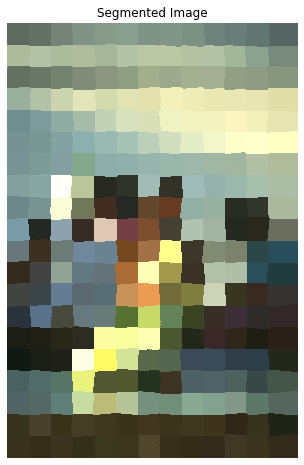

Processing image: 2018
 Initial Error =  0.3949968894870132
 Error at Convergence =  0.32558511441293964
Segmentation error =  0.7284319204719101
Boundary recall =  0.15711874827074737
Segmented Image  k =  256 and weights  m =  10 n =  24


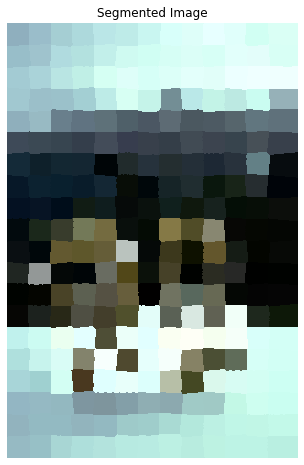

Processing image: 23050
 Initial Error =  0.39575254671064614
 Error at Convergence =  0.32583936709529493
Segmentation error =  0.9014376314570121
Boundary recall =  0.051835759325805725
Segmented Image  k =  256 and weights  m =  10 n =  24


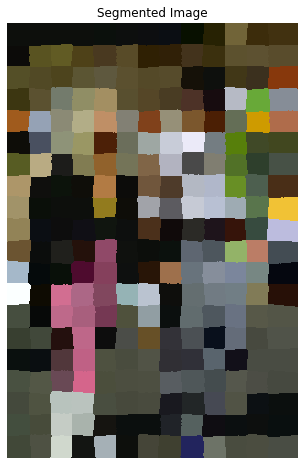

Processing image: 28083
 Initial Error =  0.39458845891652794
 Error at Convergence =  0.3258397001436122
Segmentation error =  0.5675817150333067
Boundary recall =  0.2758521985336415
Segmented Image  k =  256 and weights  m =  10 n =  24


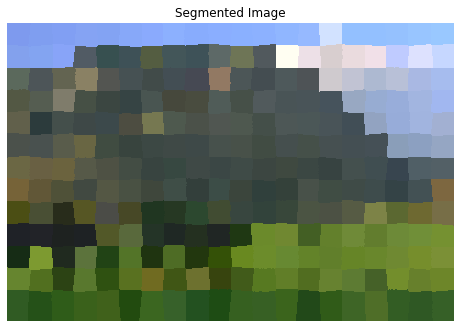

Segmentation error : [0.3897471846117767, 0.28095159757531574, 0.801775629338662, 0.642740440519598, 0.5553150659754955, 0.7134914987414075, 0.5795365663994498, 0.7284319204719101, 0.9014376314570121, 0.5675817150333067]
Boundary recall : [0.43911898266502075, 0.5613392448128054, 0.1100164988719255, 0.21747822813357506, 0.2859136323737231, 0.1672074249968783, 0.26619462672027966, 0.15711874827074737, 0.051835759325805725, 0.2758521985336415]
Mean Segmentation error : 0.6161009250123934
Mean Boundary recall : 0.25320753447044025


In [ ]:
# g) Experimenting with HSV color space for k = 256
imgPath = '/content/Part1_SLIC/BSD_data/images/';

imgList = ['14085', '14092', '15011', '15062', '16068', '17067', '20069', '2018', '23050', '28083']
# imgList = ['14085', '14092']
# metrics_array = np.zeros((3, 10))
error_matrix_new = []
recall_matrix_new = []
num = 0
for img_name in imgList:
  print("Processing image:", img_name)
  image = img_as_float(io.imread(imgPath+img_name+".jpg"))
  image = color.rgb2hsv(image)
  true_image = scipy.io.loadmat('/content/Part1_SLIC/BSD_data/groundTruth/test/' + img_name + '.mat', squeeze_me=True)
  true_seg = true_image['groundTruth'][0].item()[0]

  img_h = image.shape[0] #  Height
  img_w = image.shape[1] #  Width
  # k: Number of clusters/superpixels.
  k = 256
  N = img_h * img_w  # Total pixels in the image
  # S = int(math.sqrt(N /k)) # Average size of each superpixel
  S = int(math.sqrt(N /int(k)))
  
  m = 10  # weight for color
  n = S  # weight for spatial features

  clusters = []
  cluster_tag = np.zeros((img_h, img_w))
  dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

  clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis, m, n)

  error, recall = compute_metrics(true_seg, label(cluster_tag.astype(np.uint16))[0])

  error_matrix_new.append(error)
  recall_matrix_new.append(recall)

  print("Segmentation error = ", error)
  print("Boundary recall = ", recall)
  print("Segmented Image ", "k = ", k,"and weights ", "m = ", m, "n = ", n)
  display_clusters_hsv2rgb(image, clusters, 'Segmented Image')
  num = num + 1

print("Segmentation error :", error_matrix_new)
print("Boundary recall :", recall_matrix_new)
print("Mean Segmentation error :", np.mean(error_matrix_new))
print("Mean Boundary recall :", np.mean(recall_matrix_new))


* a) The distance function for measuring the similarity between a pixel and cluster in the 5D space is the L2 norm of the spatial distance between the pixel and cluster and the color distance between the pixel and the cluster. Each of these distances is divided by a penalty of ms(for spatial distance) and mc(for color distance) to control the relative weights for spatial distance. Smaller value of mc compared to ms gives larger importance to color distance and so on. Spatial distance ds = sqrt(square(p.h -c.h) + square(p.w -c.w)) and color distance is give as dc = sqrt(square(p.l -c.l) + square(p.a - c.a) + square(p.b - c.b)) where p and c corresponds to pixel and cluster features respectively given in 5D by (l, a, b, h, w). Distance function D = sqrt(square(ds/ms) + square(dc/mc)). (Note: In my code I have used mc = m and ms = n)

* b) The result is displayed above. Larger value of mc penalizes the color distance and larger value of ms penalizes the spatial distance. Experimenting with 3 different values of mc and ms better segmentation was achieved using mc = 17 and ms = 12.

* c) The error at initialization and at convergence is displayed for all the subtasks of the problem. The error at convergence is found to be lesser than at initialization. 

* d) The result is displayed above. The runtimes are for k = 64, runtime is 1m 6s, for k = 256, runtime is 39s and for k = 1024, the runtime is 38s. 

* e) The result for a subset of BSD images is shown above. The average runtime is 1.7 min per image.


* f) The two metrics were obtained for a subset of 10 images in the dataset for K = 64, 256 and 1024 and the mean of the metric for 10 images is plotted for every K value. The metrics are also printed for every image after the segmented image.

* g) Experimentation was done with HSV color space. Although there was not much difference in the metrics for k=256, it was found that using HSV color space was giving poorer results in the segmentation for the same values of mc, ms and k = 256 in the lab color space. Decreasing the color penalty also did not give results with comparable quality of segmentation using lab color space. Additionally, in the implementation of lab color space, the initial image was blurred using a (3, 3) kernel before finding the image gradients for cluster initialization provides to improve results. 

# Part 2: Graph-cut Segmentation 

## Data 

In [ ]:
# Download Data -- run this cell only one time per runtime
# !gdown 1ObpNoshjKMcB7SFvrTuoKe61IE-HG95n
!gdown 1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
!unzip "/content/Part2_GraphCut.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
To: /content/Part2_GraphCut.zip
100% 264k/264k [00:00<00:00, 94.2MB/s]
Archive:  /content/Part2_GraphCut.zip
   creating: /content/Part2_GraphCut/
  inflating: /content/Part2_GraphCut/dog.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._dog.jpg  
  inflating: /content/Part2_GraphCut/messi.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._messi.jpg  
  inflating: /content/Part2_GraphCut/.DS_Store  
  inflating: /content/__MACOSX/Part2_GraphCut/._.DS_Store  
  inflating: /content/Part2_GraphCut/plane.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._plane.jpg  
  inflating: /content/Part2_GraphCut/bird.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._bird.jpg  
  inflating: /content/Part2_GraphCut/cat.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._cat.jpg  
  inflating: /content/Part2_GraphCut/cat_poly.mat  
  inflating: /content/__MACOSX/Part2_GraphCut/._cat_poly.mat  


## Helper Functions

#### Code

In [ ]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

# Get a normalized version of the given histograms (divide by sum)
def normalize_histograms(histograms):
  return np.float32([h / h.sum() for h in histograms])


In [ ]:
from sklearn.mixture import GaussianMixture
def mask_for_fg(img, img_mask):
  #    
  # to generate foreground region (and everything else masked out).
  h, w, _ = img.shape
  fg_image = np.zeros((h, w, 3), dtype = np.uint8)
  for i in range(h):
    for j in range(w):
      if img_mask[i, j]== True:
        fg_image[i, j, :] = img[i, j, :]
      else:
        fg_image[i, j, :] = 0

  return fg_image

def mask_for_bg(img, img_mask):
  #   
  # generate background region (and everything else masked out).
  h, w, _ = img.shape
  bg_image = np.zeros((h, w, 3), dtype = np.uint8)
  for i in range(h):
    for j in range(w):
      if img_mask[i, j]== False:
        bg_image[i, j, :] = img[i, j, :]
      else:
        bg_image[i, j, :] = 0
  return bg_image


def visualize_likelihood_map(gmm_bg, gmm_fg, img):
  #  .
  h, w, _ = img.shape
  newdata = img.reshape(h*w, 3)  
  # gmm = GaussianMixture(n_components=2)
  # gmm_model = gmm.fit(newdata)
  ll_1= gmm_fg.score_samples(newdata)
  # plt.imshow(ll_1.reshape(h, w))
  l2_1= gmm_bg.score_samples(newdata)
  # plt.imshow(l2_1.reshape(h, w))
  show_image(ll_1.reshape(h, w), "Foreground Cost", scale = 1.0)
  show_image(l2_1.reshape(h, w), "Background Cost", scale = 1.0)
  return None

def gaussian_model(img):
  #  .
  # fit gaussian model on a given image.
  h, w, _ = img.shape
  newdata = img.reshape(h*w, 3)  
  gmm = GaussianMixture(n_components=2)
  gmm_model = gmm.fit(newdata)
  cluster = gmm_model.predict(newdata)
  cluster = cluster.reshape(h, w)
  gmm_labels = cluster

  return gmm_model, gmm_labels

def run_grabcut(img, bbox, iterations):
  #  .
  # You can use opencv cv2.grabCut algorithm with "cv2.GC_INIT_WITH_RECT" to implement this.
  grabcut_mask = np.zeros(img.shape[:2] ,np.uint8)
  # h, w, _ = np.shape(img)

  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)

  cv2.grabCut(img, grabcut_mask, bbox, bgdModel, fgdModel, iterations, cv2.GC_INIT_WITH_RECT)
  grabcut_mask = np.where((grabcut_mask==2)|(grabcut_mask==0),0,1).astype('uint8')
  
  bgModel, fgModel = bgdModel, fgdModel
  return (grabcut_mask, bgModel, fgModel)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


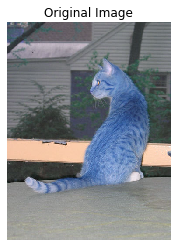

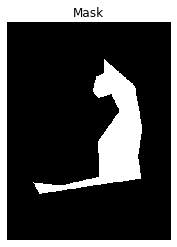

In [ ]:
### Main Block: ###

# read image
img_name = 'cat'
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

# read image_mask
poly = scipy.io.loadmat('/content/Part2_GraphCut/cat_poly.mat')['poly']
img_mask = poly2mask(poly[:,1], poly[:,0], (img.shape[0],img.shape[1]))

show_image(img, "Original Image", scale = 1.0)
show_image(img_mask, "Mask", scale = 1.0)

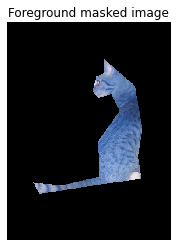

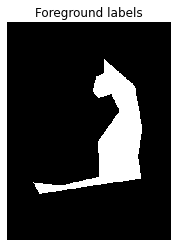

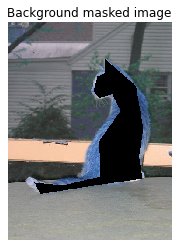

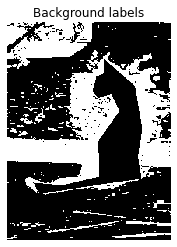

In [ ]:
# 1. Fit Gaussian mixture model for foreground regions.

# Generate image (fg_image) with background masked using img_mask
fg_image = mask_for_fg(img, img_mask)
show_image(fg_image, "Foreground masked image", scale = 1.0)
gmm_fg, fg_gmm_labels = gaussian_model(fg_image)
show_image(fg_gmm_labels, "Foreground labels", scale = 1.0)

# 2. Fit Gaussian mixture model for background regions.
# Generate image (fg_image) with foreground masked using img_mask
bg_image = mask_for_bg(img, img_mask)
show_image(bg_image, "Background masked image", scale = 1.0)
gmm_bg, bg_gmm_labels = gaussian_model(bg_image)
show_image(bg_gmm_labels, "Background labels", scale = 1.0)

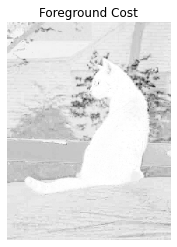

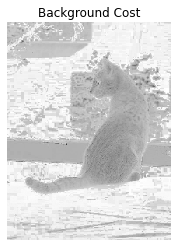

In [ ]:
# 3. Compute and visualize the foreground cost and background cost as an image.
# Foreground label cost: -log Pr[Image | foreground model]
# Foreground label cost: -log Pr[Image | background model]

visualize_likelihood_map(gmm_bg, gmm_fg, img)


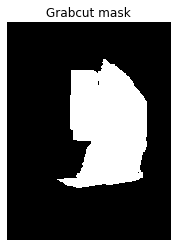

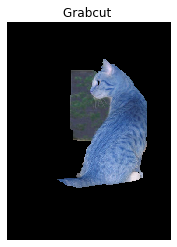

In [ ]:
# 4. Run grabcut algorithm.
# bboxes = {'cat':(80,80,320,250), 'dog':(50,300,600,300), 'plane': (180,80,250,800), 'messi':(10,80,600,500), 'bird':(100,100,350,250)}
bboxes = {'cat':(70,80,250,300), 'dog':(50,295,600,300), 'plane': (130,80,700,650), 'messi':(10,10,600,500), 'bird':(80,96,350,350)}
bbox = bboxes[img_name]
iter = 40
(grabcut_mask, bgModel, fgModel) = run_grabcut(img, bbox, iter)
show_image(grabcut_mask, 'Grabcut mask', scale = 1.0)
masked_img = img*grabcut_mask[:,:,np.newaxis]
show_image(masked_img, 'Grabcut ', scale = 1.0)



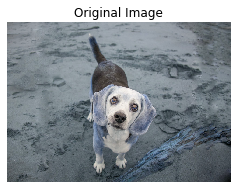

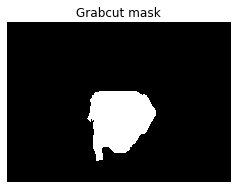

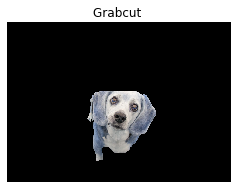

In [ ]:
img_name = 'dog'
img_path = '/content/Part2_GraphCut/dog.jpg'
img = cv2.imread(img_path)
show_image(img, 'Original Image', scale = 1.0)
bbox = bboxes[img_name]
iter = 30
(grabcut_mask, bgModel, fgModel) = run_grabcut(img, bbox, iter)
show_image(grabcut_mask, 'Grabcut mask', scale = 1.0)
masked_img = img*grabcut_mask[:,:,np.newaxis]
show_image(masked_img, 'Grabcut ', scale = 1.0)

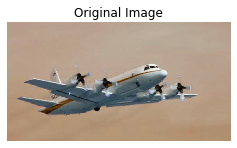

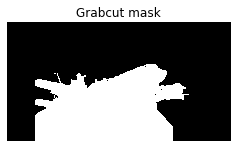

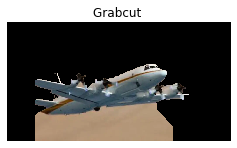

In [ ]:
img_name = 'plane'
img_path = '/content/Part2_GraphCut/plane.jpg'
img = cv2.imread(img_path)
show_image(img, 'Original Image', scale = 1.0)
bbox = bboxes[img_name]
iter = 30
(grabcut_mask, bgModel, fgModel) = run_grabcut(img, bbox, iter)
show_image(grabcut_mask, 'Grabcut mask', scale = 1.0)
masked_img = img*grabcut_mask[:,:,np.newaxis]
show_image(masked_img, 'Grabcut ', scale = 1.0)

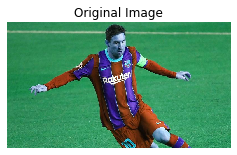

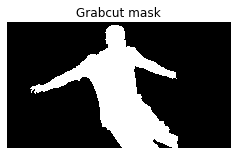

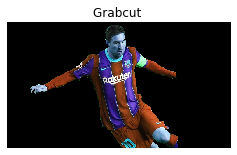

In [ ]:
img_name = 'messi'
img_path = '/content/Part2_GraphCut/messi.jpg'
img = cv2.imread(img_path)
show_image(img, 'Original Image', scale = 1.0)
bbox = bboxes[img_name]
iter = 5
(grabcut_mask, bgModel, fgModel) = run_grabcut(img, bbox, iter)
show_image(grabcut_mask, 'Grabcut mask', scale = 1.0)
masked_img = img*grabcut_mask[:,:,np.newaxis]
show_image(masked_img, 'Grabcut ', scale = 1.0)

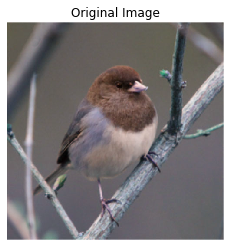

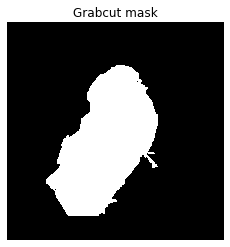

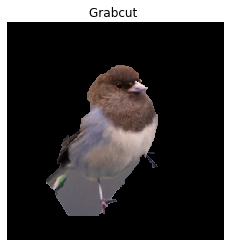

In [ ]:
img_name = 'bird'
img_path = '/content/Part2_GraphCut/bird.jpg'
img = cv2.imread(img_path)
show_image(img, 'Original Image', scale = 1.0)
bbox = bboxes[img_name]
iter = 15
(grabcut_mask, bgModel, fgModel) = run_grabcut(img, bbox, iter)
show_image(grabcut_mask, 'Grabcut mask', scale = 1.0)
masked_img = img*grabcut_mask[:,:,np.newaxis]
show_image(masked_img, 'Grabcut ', scale = 1.0)

-->
* a) The foreground likelihood function is give as -log Pr[Image | foreground model] and the background likelihood function is given as -log Pr[Image | background model]. The likelihood function shows that the probability of pixels which lie in the foreground is higher given a GMM foreground model and probability of pixels which lie in the background is higher given a GMM background model.
* b)The foreground and background likelihood map is displayed above in #3 subpart.
* c) The grabcut algorithm was implemented for 5 different images using the rectangular mode of the cv2 package for 5 iterations each. It was observed that the segmentation results were accurate for 'Messi' and 'bird' image,for the 'plane' and 'cat' images, some part of the background was also included and for the 'dog' image, some portion of the dog's body was not included in the part segmented out, possibily due to similarity between the background and that portion.


refer to https://docs.opencv.org/4.x/dd/dfc/tutorial_js_grabcut.html to implement run_grabcut()